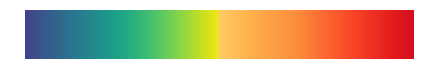

In [100]:
%matplotlib inline 
import os,sys
import pandas as pd 
import numpy as np 
import nibabel as nb 
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib import cm
import os 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from nilearn.image import concat_imgs, index_img
from matplotlib import colors
import seaborn as sns 
from sklearn import preprocessing
from scipy import cluster
from sklearn.cluster import AgglomerativeClustering

sys.path.append('/Users/kanaan/SCR/Github/GluIRON/')

ahba_dir     = '/Users/kanaaax/Google Drive/TS-EUROTRAIN/RESULTS_QSMv3/dataframes'
save_fig_dir = '/Users/kanaaax/Google Drive/TS-EUROTRAIN/Papers/2019_QSM_paper/Figures_python_v4'


cmap_drysdale = colors.ListedColormap(['#00ffff', '#00afff','#0000ff', '#260000', '#530000','#fe0000', '#ff6a00', '#ffff00'])
cmap_ted = colors.ListedColormap(['#00ffff', '#00afff','#0000ff', '#260000', '#530000','#fe0000', '#ff6a00','#ffff00', '#ffffff'])
cmap_rdbu = colors.ListedColormap(['#d73027', '#fc8d59', '#fee090', '#e0f3f8', '#91bfdb', '#4575b4'][::-1])
cmap_rdbu2 = colors.ListedColormap(['#cb1a1e', '#e1817f', '#f1bebe', '#e0f3f8', '#91bfdb', '#4575b4'][::-1])

first = int((128*2)-np.round(255*(1.-0.50)))
second = (256-first)
colors2 = plt.cm.viridis(np.linspace(0.2, .98, first))
colors3 = plt.cm.YlOrRd(np.linspace(0.3, 0.8, second))
colors4 = plt.cm.PuBu(np.linspace(0., 0.25, second))

cols = np.vstack((colors2,colors3))
cmap_gradient = colors.LinearSegmentedColormap.from_list('my_colormap', cols)

num = 256
gradient = range(num)
for x in range(5):
    gradient = np.vstack((gradient, gradient))

fig, ax = plt.subplots(nrows=1)
ax.imshow(gradient, cmap=cmap_gradient, interpolation='nearest')
ax.set_axis_off()
fig.tight_layout()

plt.show()


In [101]:
dict_ontology = { 
                    
'basal forebrain'      : '00_CTX',
'cingulate gyrus'      : '00_CTX', 
'claustrum'            : '00_CTX', 
'frontal lobe'         : '00_CTX', 
'insula'               : '00_CTX', 
'occipital lobe'       : '00_CTX', 
'parietal lobe'        : '00_CTX', 
'sulci & spaces'       : '00_CTX', 
'temporal lobe'        : '00_CTX', 
'brain'                : '00_CTX', 
'parahippocampal gyrus': '02_AMG',
'hippocampal formation': '02_AMG', 
'amygdala'             : '02_AMG', 
'striatum'             : '03_BG', 
'globus pallidus'      : '03_BG', 
'hypothalamus'         : '05_TH',
'epithalamus'          : '05_TH', 
'subthalamus'          : '05_TH', 
'ventral thalamus'     : '05_TH', 
'dorsal thalamus'      : '05_TH', 
'cerebellar cortex'    : '06_CB', 
'cerebellar nuclei'    : '06_CB', 
'basal part of pons'   : '07_P',
'pontine tegmentum'    : '07_P',
'mesencephalon'        : '08_MB', 
'myelencephalon'       : '09_WM', 
'white matter'         : '09_WM'
}
                 

# READ AHBA DATA 

In [102]:
def return_ahba_data():
    
    AHBA = pd.read_csv(os.path.join(ahba_dir, 'AHBA/AHBA_data/AHBA_20737.csv'),index_col=0)
    META = AHBA.iloc[:,-28:]
    #add ontology
    IRON_H = pd.read_csv(os.path.join(ahba_dir, 'AHBA/AHBA_IRON_HOMEOSTASIS.csv'),index_col=0)
    for i in IRON_H.index:
        top_struct= IRON_H.loc[i]['top_struct']
        IRON_H.loc[i, 'STRUCT'] = dict_ontology[top_struct]

    for i in AHBA.index:
        AHBA.loc[i, 'STRUCT'] =IRON_H.loc[i]['STRUCT']
        AHBA.loc[i, 'STRUCT_CAT'] = float(AHBA.loc[i, 'STRUCT'][0:2])

    # scale

    AHBA = AHBA.sort_values(by=['STRUCT'])
    df = AHBA.iloc[:,:-32]

    x = df.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled, columns=AHBA.iloc[:,:-32].columns, index=AHBA.iloc[:,:-32].index)
    return df 
    

In [103]:
# Read AHBA db
AHBA = return_ahba_data()

In [104]:
# Define AHBA in striatal subdivisions

def return_str_index(nuc):
    
    wells = pd.read_csv(os.path.join(ahba_dir, 'AHBA/AHBA_data/index/chi_index_%s_tstat_CP_1mm.csv'%nuc),index_col=0)
    
    return wells.index

strM_wells =return_str_index('STR3_MOTOR')
strE_wells =return_str_index('STR3_EXEC')
strL_wells =return_str_index('STR3_LIMBIC')

AHBA_strM = AHBA.drop([i for i in AHBA.index if i not in strM_wells],axis=0)
AHBA_strE = AHBA.drop([i for i in AHBA.index if i not in strE_wells],axis=0)
AHBA_strL = AHBA.drop([i for i in AHBA.index if i not in strL_wells],axis=0)

In [109]:
def make_clust_plot(df, cmap,fname):
    #scale data
    x = df.values
    df = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(x))
   
    c = sns.clustermap(df, cmap=cmap)
    df = df.reindex(index=c.dendrogram_row.reordered_ind, columns=c.dendrogram_col.reordered_ind)
    
    fig = plt.figure(figsize=(5, 10))
    sns.heatmap(df, cmap = cmap, xticklabels=False, yticklabels=False, cbar=False,vmin=0,vmax=0.85)
    plt.savefig(os.path.join(save_fig_dir, fname), 
                transparent= True, bbox_inches= 'tight', 
                dpi=500, xticklabels=False, yticklabels=False)



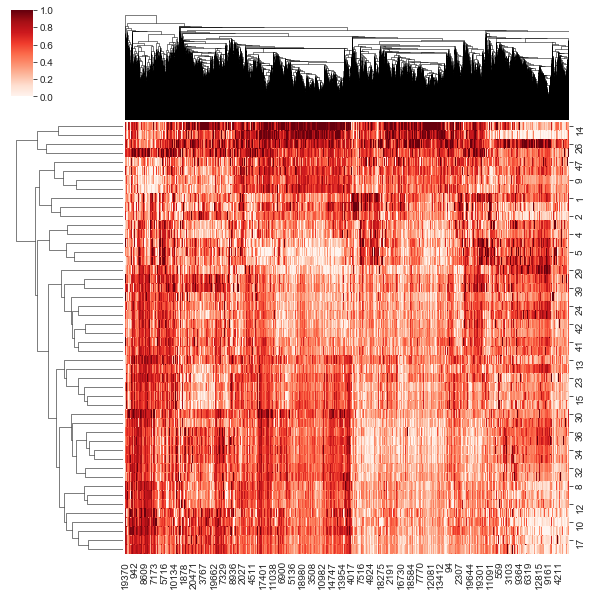

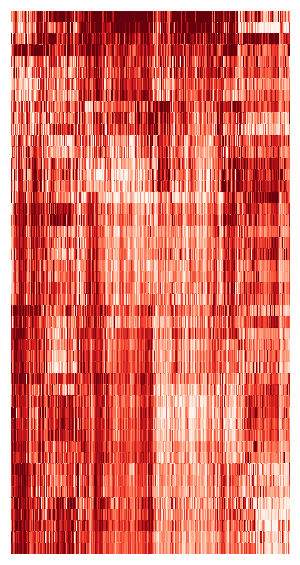

In [110]:
make_clust_plot(AHBA_strM, 'Reds', 'methods_ahba_motor')

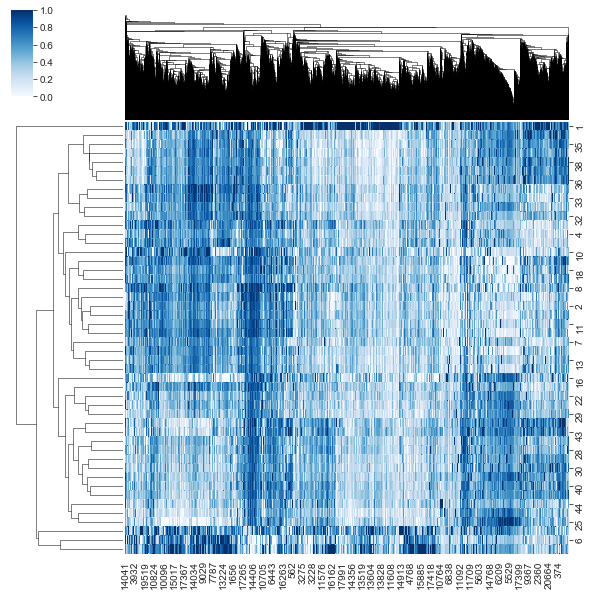

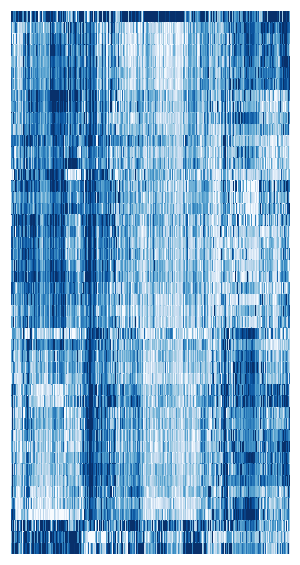

In [111]:
make_clust_plot(AHBA_strE, 'Blues', 'methods_ahba_exec')

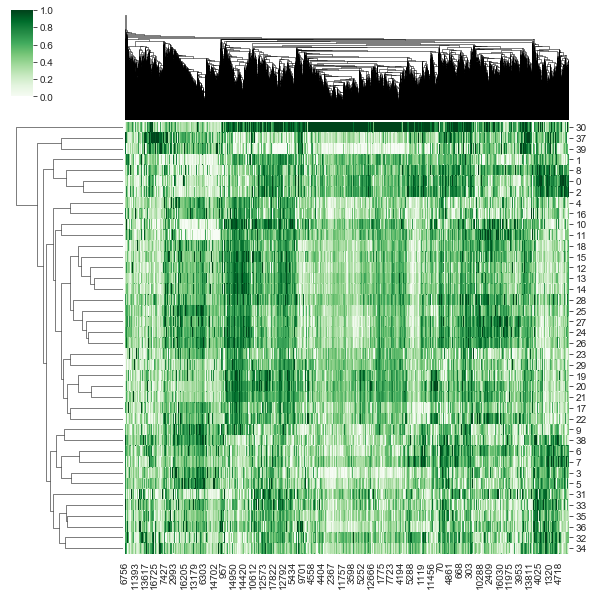

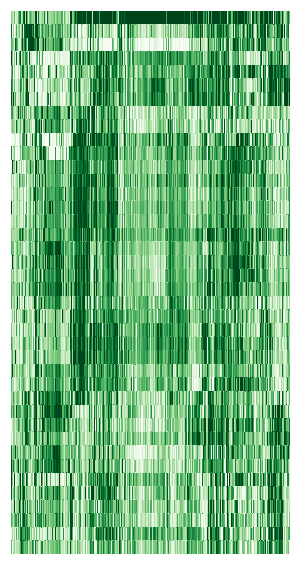

In [112]:
make_clust_plot(AHBA_strL, 'Greens', 'methods_ahba_limbic')

In [60]:
def make_clust_plot_full(df, cmap):
    #scale data
    x = df.values
    df = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(x))
    c = sns.clustermap(df, cmap=cmap)
    df = df.reindex(columns=c.dendrogram_col.reordered_ind)

    return df


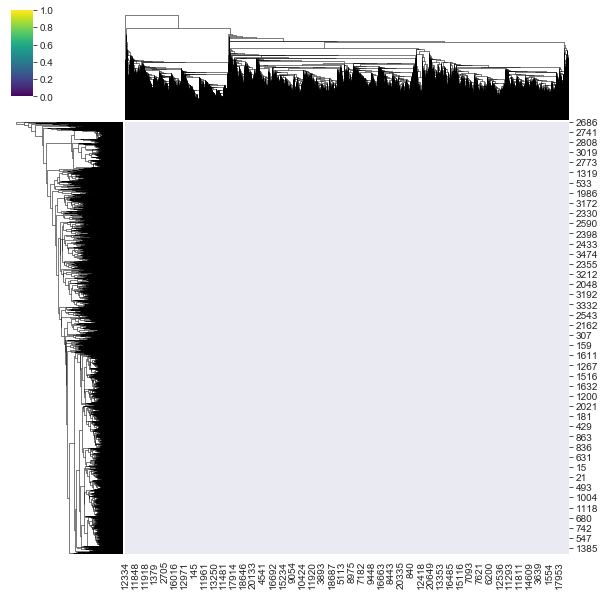

In [61]:
ahba_clust = make_clust_plot_full(AHBA, 'viridis')

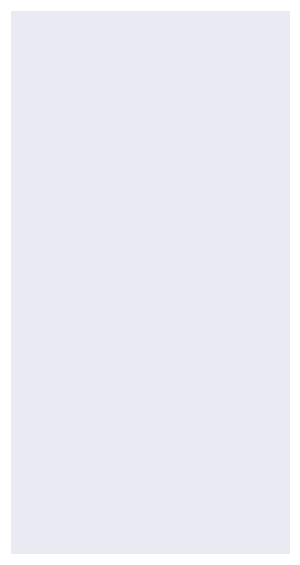

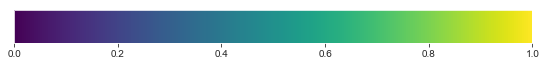

In [68]:
fname = 'methods_ahba_full'
cmap  = 'viridis'

fig = plt.figure(figsize=(5, 10))

sns.heatmap(ahba_clust.iloc[0:3702,:], cmap = cmap, xticklabels=False, yticklabels=False, cbar=False,vmin=0,vmax=.75)
plt.savefig(os.path.join(save_fig_dir, fname), 
            transparent= True, bbox_inches= 'tight', 
            dpi=500, xticklabels=False, yticklabels=False)

plot_cmap(cmap, 'ahba')



# PLOT QSM 

In [6]:
#def plot_str_voxels():
str4d = nb.load(os.path.join(ahba_dir, 'str_concat.nii.gz')).get_data()

In [7]:
def plot_cmap(cmap, fname):
    import matplotlib.pyplot as plt
    import matplotlib as mpl

    fig = plt.figure(figsize=(8, 3))
    ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])

    cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap, orientation='horizontal')
    plt.tick_params(None)
    plt.savefig('%s/cmap_%s_cmap.png' %(save_fig_dir, fname), dpi = 300, transparent = True)



In [8]:
str4d.shape

(182, 218, 182, 51)

In [47]:
n_subjects = str4d.shape[-1]
n_voxels   = 14000
str_voxels = []
for i in range(n_subjects):
    img = str4d[:,:,:,i].ravel()
    img[img==0] = np.nan
    img = img[~np.isnan(img)][0:n_voxels]
    str_voxels.append(img)

str_matrix = np.concatenate(str_voxels).reshape(n_voxels,n_subjects).T

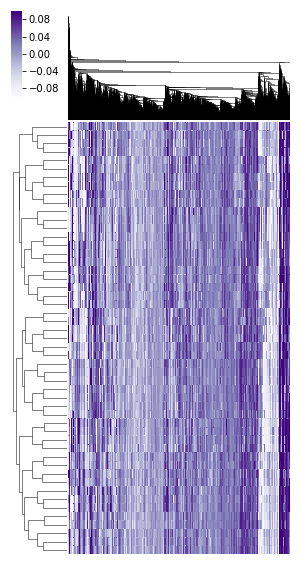

In [48]:
cg=sns.clustermap(str_matrix, cmap='Purples',
                  xticklabels=False, 
                  yticklabels=False, 
                  cbar=True, 
                  col_cluster=1,
                  row_cluster=1, 
                  figsize = (5,10),
                  vmin = -.1,vmax=0.1)



In [89]:
df_str_matrix = pd.DataFrame(str_matrix).reindex(#index = cg.dendrogram_row.reordered_ind, 
                                                 columns = cg.dendrogram_col.reordered_ind)


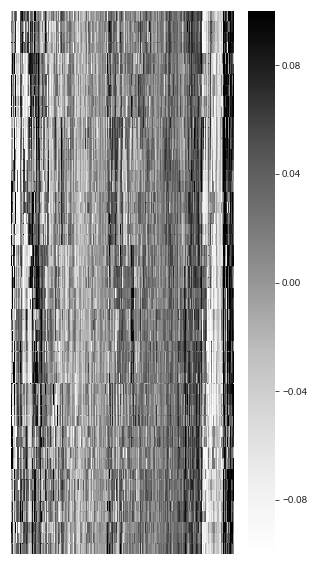

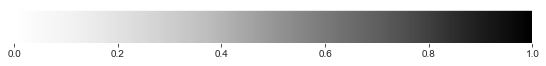

In [90]:
cmap = 'Greys'
fig = plt.figure(figsize=(5, 10))
sns.heatmap(df_str_matrix, cmap = cmap, cbar=True, vmin = -.1, vmax =.1, xticklabels=False, yticklabels=False)
plt.savefig(os.path.join(save_fig_dir, 'methods_qsm_str.png'), transparent= True, bbox_inches= 'tight', dpi=200)
plot_cmap(cmap, 'qsm')


In [141]:
pd.DataFrame(str_matrix).shape

(1000, 51)

In [139]:
pd.DataFrame(str_matrix).reindex?

Object `reindex` not found.


In [ ]:
pd.DataFrame(str_matrix).reindex

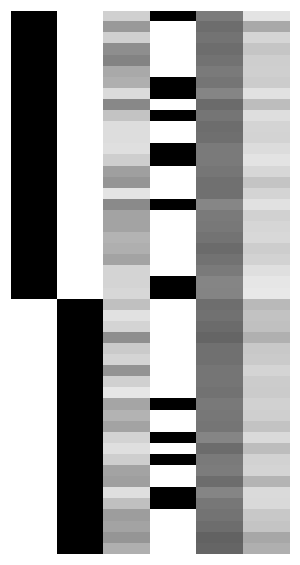

In [57]:
def plt_design_matrx():
    import seaborn as sns 
    sns.set_style('darkgrid')

    design_matrix = pd.read_csv(os.path.join(ahba_dir, 'design_twosample_CP.mat'),
                               sep='\t', skiprows=[0,1,2], header=None)
    design_matrix.columns = ['HC', 'GTS', 'Age', 'Gender', 'QI1', 'EFC']
    design_matrix.Age = design_matrix.Age/100
    design_matrix.head()

    import seaborn as sns 
    fig = plt.figure(figsize=(5, 10))
    #fig.add_subplot(111)
    #ax = plt.imshow(design_matrix, cmap='jet')
    sns.heatmap(design_matrix, cmap='Greys', cbar = 0, vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])
    #sns.despine(top=False)
    plt.savefig(os.path.join(save_fig_dir, 'methods_randomise_design_matrix.png'), transparent=1, bbox_inches='tight')
plt_design_matrx()

In [114]:
str_matrix.shape

(10000, 51)

In [98]:

def plot_cmap(cmap, fname):
    import matplotlib.pyplot as plt
    import matplotlib as mpl

    fig = plt.figure(figsize=(8, 3))
    ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])

    cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap, orientation='horizontal')
    plt.tick_params(None)

def plot_striatum(overlay, coords):
    import nibabel as nb 
    import numpy as np
    import matplotlib.pyplot as plt 
    import matplotlib
    from matplotlib import colors
    img_underlay = np.rot90(nb.load('/usr/local/fsl/data/standard/MNI152_T1_1mm.nii.gz').get_data())
    cmap1 = matplotlib.cm.gray

    if overlay == 'tstat':
        img_overlay = np.rot90(nb.load('/Users/kanaaax/SCR/Github/IRON/atlases/PLOT/randomise_CP_STR_tstat1.nii.gz').get_data())
        cmap2 = matplotlib.cm.hot
        cmap_name='hot_r'
        vmin = -2.
        vmax = +3.
    elif overlay == 'mask':
        img_overlay = np.rot90(nb.load('/Users/kanaaax/SCR/Github/IRON/atlases/PLOT/MAN_STR_ALL.nii.gz').get_data())
        cmap2 = colors.ListedColormap(['lime', 'b', 'r'])
        cmap_name = 'str3'
        vmin = 1.
        vmax = 3.
    
    img_overlay[img_overlay==0] = np.nan

    fig =plt.figure()
    fig.set_size_inches(10, 10.5)
    fig.subplots_adjust(wspace=0.0000005, hspace=0.0000005, bottom = 0.1)

    ax1 = plt.subplot2grid((3,2), (0,0),  colspan = 1, rowspan =1)
    ax2 = plt.subplot2grid((3,2), (1,0),  colspan = 1, rowspan =1)
    ax3 = plt.subplot2grid((3,2), (2,0),  colspan = 1, rowspan =1)

    ax4 = plt.subplot2grid((3,2), (0,1),  colspan = 1, rowspan =1)
    ax5 = plt.subplot2grid((3,2), (1,1),  colspan = 1, rowspan =1)
    ax6 = plt.subplot2grid((3,2), (2,1),  colspan = 1, rowspan =1)

    coord1 = 86
    coord2 = 89
    coord3 = 94

    ax1.imshow(np.rot90(img_underlay[coord1,:,:]), cmap1)
    ax1.imshow(np.rot90(img_overlay[coord1,:,:]),  cmap2, vmin = vmin, vmax = vmax)
    ax2.imshow(np.rot90(img_underlay[coord2,:,:]), cmap1)
    ax2.imshow(np.rot90(img_overlay[coord2,:,:]),  cmap2, vmin = vmin, vmax = vmax)
    ax3.imshow(np.rot90(img_underlay[coord3,:,:]), cmap1)
    ax3.imshow(np.rot90(img_overlay[coord3,:,:]),  cmap2, vmin = vmin, vmax = vmax)

    coord4 = 65
    coord5 = 73
    coord6 = 80
    ax4.imshow(img_underlay[:,:,coord4], cmap1)
    ax5.imshow(img_underlay[:,:,coord5], cmap1)
    ax6.imshow(img_underlay[:,:,coord6], cmap1)
    
    ax4.imshow(img_overlay[:,:,coord4], cmap2, vmin = vmin, vmax = vmax)
    ax5.imshow(img_overlay[:,:,coord5], cmap2, vmin = vmin, vmax = vmax)
    ax6.imshow(img_overlay[:,:,coord6], cmap2, vmin = vmin, vmax = vmax)

    for ax in [ax1, ax2, ax3]:
        ax.axes.get_yaxis().set_visible(False)
        ax.axes.get_xaxis().set_visible(False)
        ax.set_xlim(45, 135)
        ax.set_ylim(135, 70)
        
    for ax in [ax4, ax5, ax6]:
        ax.axes.get_yaxis().set_visible(False)
        ax.axes.get_xaxis().set_visible(False)
        ax.set_xlim(45, 135)
        ax.set_ylim(120, 55)
    
    fig.tight_layout()
    plt.savefig('%s/methods_plot_str_%s.png' %(save_fig_dir, overlay), dpi = 300, transparent = True )
    #plot_cmap(colors.ListedColormap(['b', 'lime', 'r']), cmap_name)
    plot_cmap(cmap2, cmap_name)
    plt.savefig('%s/methods_plot_str_%s_cmap.png' %(save_fig_dir, overlay), dpi = 300, transparent = True )


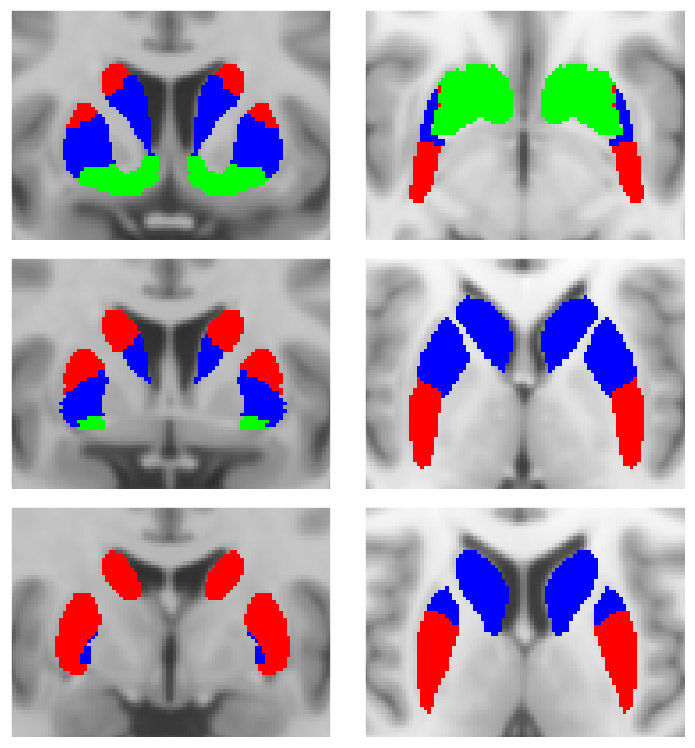

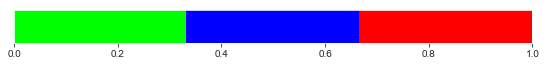

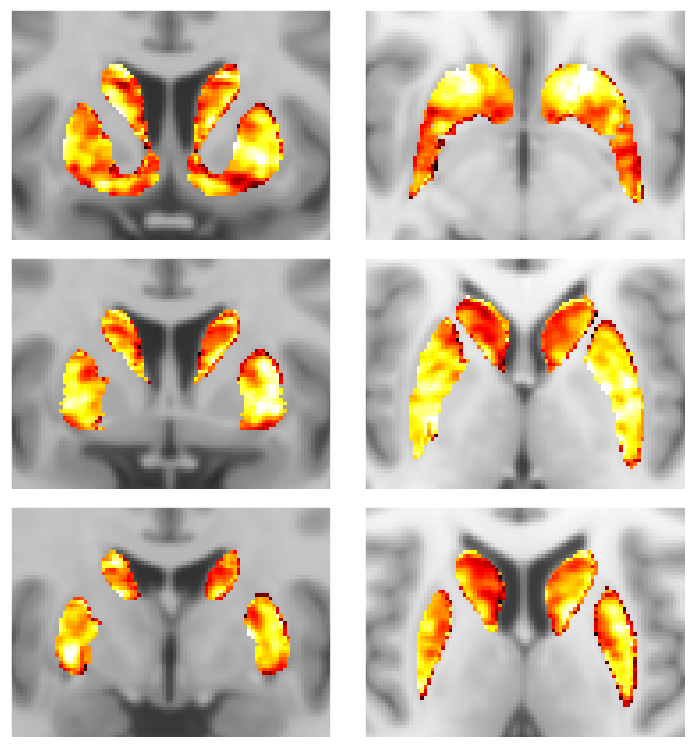

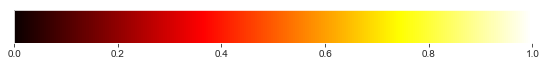

In [99]:
plot_striatum('mask', None)
plot_striatum('tstat', None)
